# Import questions 

In [186]:
%reload_ext autoreload
%autoreload 2

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from itertools import product
from pathlib import Path

%matplotlib inline
sns.set_style('white')

warnings.filterwarnings('ignore')

In [190]:
dirpath = Path("data")
df = pd.read_json(dirpath / "questions.json").T
df.head()

,sentence,tags
1987694,"How do I print the full NumPy array, without t...","[python, arrays, numpy, output-formatting]"
1988804,What is memoization and how can I use it in Py...,"[python, memoization]"
1993727,Expanding tuples into arguments,"[python, tuples, parameter-passing]"
1995615,How can I format a decimal to always show 2 de...,"[python, string-formatting]"
2018026,"What are the differences between the urllib, u...","[python, python-requests, urllib, urllib2, url..."


In [ ]:
df.head()

,sentence,tags
55934019,Randomness of Python&#39;s random,"[python, random]"
56119490,cx_Oracle error. DPI-1047: Cannot locate a 64-...,"[python, python-3.x, windows-10, cx-oracle]"
56127592,AttributeError: module &#39;tensorflow&#39; ha...,"[python, tensorflow]"
56134588,Is that a bad idea to use conda and pip instal...,"[python, pip, virtualenv, conda]"
56155627,RequestsDependencyWarning: urllib3 (1.25.2) or...,"[python, pip, importerror, archlinux]"


# Preprocessing

In [280]:
import pyLDAvis
import re
import spacy

from pprint import pprint

from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel

from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import LabelEncoder 

In [192]:
# Load the spacy package
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [193]:
def flatten_tags(tag_column):
    return [tag for row in tag_column for tag in sorted(row)]


def label_encode_tags(tags):
    return LabelEncoder().fit_transform(tags)


def get_tags(ctf, n):
    vocab_freq = zip(ctf.get_feature_names_out(), 1 / ctf.idf_)
    top_vocab = sorted(vocab_freq, key=lambda item: item[1], reverse=True)[:n]
    return [v[0] for v in top_vocab]


def clean_text(text: str) -> str:
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)


def text_preprocessing(
        text: str, 
        nlp: spacy.lang.en.English,
        pos: list[str] = ["NOUN", "ADJ", "VERB", "ADV"],
        kind: str = "bow", # "bow" or "dl"
        lemma: bool = False,
) -> str:
    """
    Preprocess a text by converting it to lower case, filtering alphanumeric characters and postags, and lemmatizing the tokens.

    Args:
        text (str): the string to be preprocessed
        pos (list[str], optional): the postags to keep in the text. Defaults to ["NOUN", "ADJ", "VERB", "ADV"].
        kind (str, optional): the kind of preprocessing, either "bow" (bag-of-words) or "dl" (deep learning). Defaults to "bow".
        lemma (bool, optional): whether to lemmatize the token or not, ignored if kind = "dl". Defaults to False.
        package (str, optional): the spaCy package to import for NLP. Defaults to "en_core_web_sm".

    Raises:
        ValueError: incompatible values for lemma and kind.
        ValueError: unknown kind argument.

    Returns:
        str: the preprocessed version of the input text.
    """    
    cleaned_text = clean_text(text.lower()).replace("  ", " ").strip()

    # For deep learning, only remove the non-alphanumeric characters
    if kind == "dl": 
        return cleaned_text
    
    # For bag of words, remove the stop words and lemmatize if indicated
    elif kind == "bow":
        token_list = [
            tk for tk in nlp(cleaned_text) if tk.pos_ in pos
        ]
        output_text = " ".join([
            tkl.lemma_ if lemma else tkl.text for tkl in token_list
        ])
        return output_text

In [194]:
df['sentence_bow'] = df['sentence'].apply(lambda x : text_preprocessing(x, nlp=nlp))
df['sentence_bow_lem'] = df['sentence'].apply(lambda x : text_preprocessing(x, nlp=nlp, lemma=True))
df['sentence_dl'] = df['sentence'].apply(lambda x : text_preprocessing(x, nlp=nlp, kind="dl"))

# df['length_bow'] = df['sentence_bow'].apply(lambda x : len(x.split()))
# df['length_dl'] = df['sentence_dl'].apply(lambda x : len(x.split()))

# Unsupervised

In [195]:
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_transform = cvect.fit_transform(df[feat])  
ctf_transform = ctf.fit_transform(df[feat])  

## T-SNE

In [196]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=2000,
    init='random',
    learning_rate=200,
    random_state=42
)

cv_tsne = tsne.fit_transform(cv_transform)
ctf_tsne = tsne.fit_transform(ctf_transform)

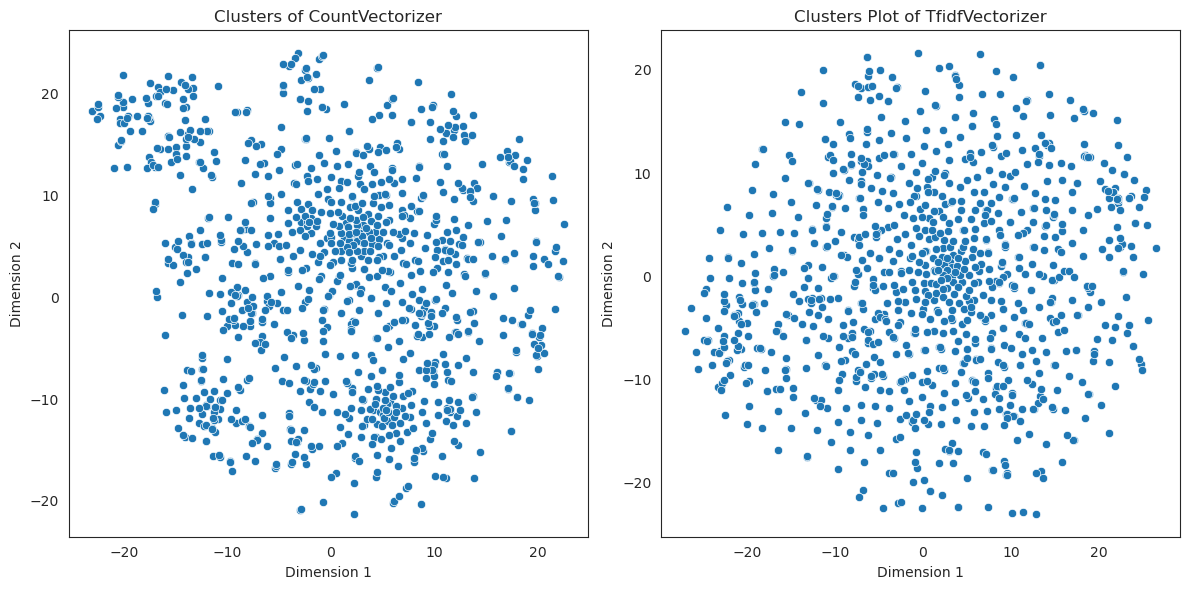

In [197]:
cv_points = pd.DataFrame(
    cv_tsne,
    columns=['Dimension 1', 'Dimension 2'],
    index=df.index
)
ctf_points = pd.DataFrame(
    ctf_tsne,
    columns=['Dimension 1', 'Dimension 2'],
    index=df.index
)

fig = plt.figure(figsize=(12, 6))

fig.add_subplot(121)
sns.scatterplot(
    data=cv_points,
    x='Dimension 1',
    y='Dimension 2',
    palette='rainbow'
)
plt.title('Clusters of CountVectorizer')

fig.add_subplot(122)
sns.scatterplot(
    data=ctf_points,
    x='Dimension 1',
    y='Dimension 2',
    palette='rainbow'
)
plt.title('Clusters Plot of TfidfVectorizer')

plt.tight_layout()

## Clustering

In [198]:
cv_clusters = pd.DataFrame(index=df.index)
cv_inertia = []

### K-Means

In [219]:
for n in range(2, 21):
    kmeans = KMeans(n_clusters=n, n_init=100, random_state=42)
    cv_fit = kmeans.fit(cv_tsne)
    cv_clusters[f'kmeans {n} clusters'] = cv_fit.labels_
    cv_inertia.append(cv_fit.inertia_)

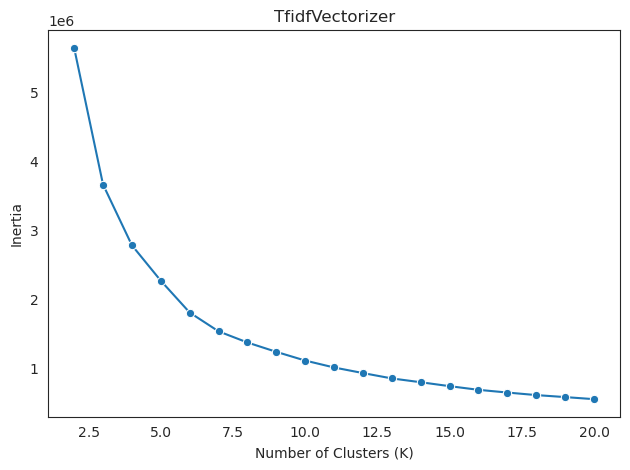

In [220]:
sns.lineplot(x=range(2, 21), y=ctf_inertia, marker='o')
plt.title('TfidfVectorizer')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')

plt.tight_layout()

### DBSCAN

In [225]:
# List of all the values taken by the params
param_grid = {
    'eps': [i/10 for i in range(1, 20)],
    'min_samples': range(3, 10)
}

for (eps, min_samples) in list(
    product(param_grid['eps'], param_grid['min_samples'])
):
    try:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        cv_clusters[f'dbscan eps_{eps}_ms_{min_samples}'] = dbscan.fit(cv_tsne).labels_
        score_cv = silhouette_score(
            pd.DataFrame(cv_tsne),
            cv_clusters[f'dbscan eps_{eps}_ms_{min_samples}']
        )
        n_cluster = len(
            cv_clusters[f'dbscan eps_{eps}_ms_{min_samples}'].value_counts()
        )
        if n_cluster > 10 and score_cv > 0.1:
            print(f'eps={eps}, min_sample={min_samples}:')
            print('silouette score =', score_cv)
            print('n clusters =', n_cluster)
            print('--------------------------------------------------------------')
    except ValueError:
        continue

eps=1.8, min_sample=5:
silouette score = 0.107410125
n clusters = 17
--------------------------------------------------------------
eps=1.8, min_sample=7:
silouette score = 0.10264607
n clusters = 19
--------------------------------------------------------------
eps=1.8, min_sample=9:
silouette score = 0.11432852
n clusters = 21
--------------------------------------------------------------


In [226]:
k = 7
eps = 1.8
min_samples = 9

## Visualize clusters

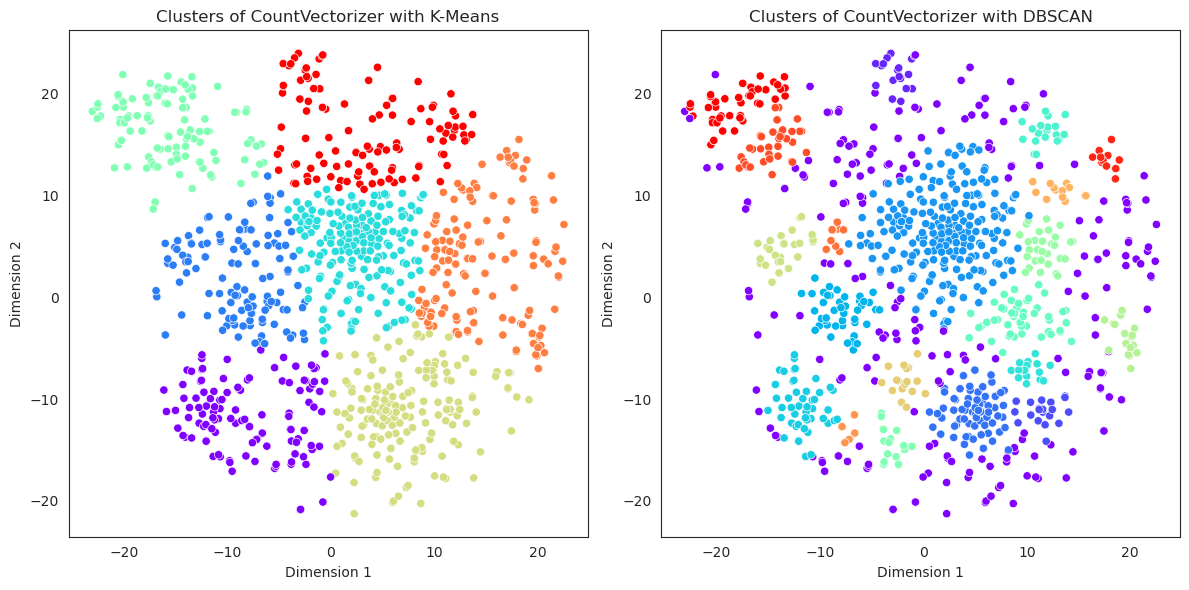

In [227]:
fig = plt.figure(figsize=(12, 6))

fig.add_subplot(121)
sns.scatterplot(
    data=cv_points,
    x='Dimension 1',
    y='Dimension 2',
    hue=cv_clusters[f'kmeans {k} clusters'],
    palette='rainbow'
)
plt.legend().set_visible(False)
plt.title('Clusters of CountVectorizer with K-Means')

fig.add_subplot(122)
sns.scatterplot(
    data=cv_points,
    x='Dimension 1',
    y='Dimension 2',
    hue=cv_clusters[f'dbscan eps_{eps}_ms_{min_samples}'],
    palette='rainbow'
)
plt.legend().set_visible(False)
plt.title('Clusters of CountVectorizer with DBSCAN')

plt.tight_layout()

## Generate tags

In [228]:
df_with_clusters = pd.concat(
    [
        df,
        cv_clusters[f'kmeans {k} clusters'],
        cv_clusters[f'dbscan eps_{eps}_ms_{min_samples}']
    ], axis=1
)

In [229]:
for col in ["sentence_bow", "sentence_bow_lem"]:
    df_with_clusters[col] = df_with_clusters[col].str.split()

In [230]:
group_dbscan = df_with_clusters.groupby(f'dbscan eps_{eps}_ms_{min_samples}')
group_kmeans = df_with_clusters.groupby(f'kmeans {k} clusters')

In [255]:
lda_models = {}  # Dict to store LDA models for each cluster
tags_per_question = {}  # Dict to store tags for each question in each cluster
topn = 5

for cluster_label in group_dbscan.groups:
    data = group_dbscan.get_group(cluster_label)["sentence_bow_lem"]
    id2word = corpora.Dictionary(data)
    corpus = [id2word.doc2bow(text) for text in data]

    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=topn, 
        passes=10,
        random_state=42,
    )
    lda_models[cluster_label] = {
        'model': lda_model,
        'dictionary': id2word,
        'questions': data,
        'corpus': corpus
    }

    # Assign tags to questions in the current cluster
    tags_per_question[cluster_label] = []
    for question_bow in corpus:
        topic_distribution = lda_model[question_bow]
        # Get the top keywords for each topic
        topic_keywords = lda_model.print_topic(
            max(topic_distribution, key=lambda item: item[1])[0], topn=topn
        )
        # Extract tags from keywords
        tags = [
            word.split("*")[1].replace('"', '') 
            for word in topic_keywords.split(" + ")
        ]
        tags_per_question[cluster_label].append(tags)


In [256]:
for cluster_label in lda_models:
    lda_model = lda_models[cluster_label]
    coherence = CoherenceModel(
        model=lda_model['model'],
        texts=lda_model['questions'],
        dictionary=lda_model['dictionary'],
        coherence='c_v'
    )
    print(cluster_label, ': Coherence =', round(coherence.get_coherence(), 2))
    print("Tags :")
    pprint(tags_per_question[cluster_label][:5])
    print('------------------------------------------------------')

-1 : Coherence = 0.59
Tags :
[['python', 'request', 'byte', 'error', 'multiple'],
 ['python', 'package', 'install', 'find', 'panda'],
 ['panda', 'numpy', 'module', 'get', 'group'],
 ['python', 'request', 'byte', 'error', 'multiple'],
 ['python', 'request', 'byte', 'error', 'multiple']]
------------------------------------------------------
0 : Coherence = 0.56
Tags :
[['array', 'numpy', 'remove', 'value', 'frequency'],
 ['numpy', 'array', 'value', 'r', 'index'],
 ['array', 'convert', 'difference', 'display', 'image'],
 ['array', 'numpy', 'print', 'convert', 'unison'],
 ['array', 'numpy', 'difference', 'element', 'column']]
------------------------------------------------------
1 : Coherence = 0.57
Tags :
[['python', 'use', 'class', 'get', 'selenium'],
 ['python', 'use', 'loop', 'django', 'json'],
 ['use', 'python', 'good', 'practice', 'else'],
 ['python', 'thread', 'use', 'way', 'correct'],
 ['python', 'thread', 'use', 'way', 'correct']]
------------------------------------------------

In [288]:
lda_model = lda_models[0]
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(
    lda_model['model'],
    lda_model['corpus'],
    lda_model['dictionary']
)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.017588 -0.095354       1        1  27.495647
4     -0.052924 -0.020808       2        1  21.301304
3      0.095717  0.036441       3        1  20.109319
2     -0.069682  0.046259       4        1  19.435881
1      0.009301  0.033462       5        1  11.657849, topic_info=          Term      Freq     Total Category  logprob  loglift
16  difference  3.000000  3.000000  Default  30.0000  30.0000
50           r  1.000000  1.000000  Default  29.0000  29.0000
9      display  1.000000  1.000000  Default  28.0000  28.0000
10       image  1.000000  1.000000  Default  27.0000  27.0000
47     asarray  1.000000  1.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
46    specific  0.110221  1.341439   Topic5  -4.6908  -0.3498
28        dump  0.110221  1.341439   Topic5  -4.6908  -0.3498
4   truncation  0.110220  1.341439   Topic5  -4.6908  -0.3498
29        file  0.110220  1.341439   Topic5  -4.6908  -0.3498
42      unique  0.110219  1.341440   Topic5  -4.6908  -0.3498

[241 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
19        4  0.770919  access
34        2  0.759821     add
0         1  0.330584   array
0         2  0.198350   array
0         3  0.198350   array
...     ...       ...     ...
7         1  0.592900   value
7         2  0.296450   value
25        3  0.757780     way
26        3  0.757780    well
39        4  0.770919    wise

[71 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])

# Supervised